In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make plots show up nicely in the notebook
%matplotlib inline

# Robust project root detection:
# - If you run the notebook from /notebooks, this moves one level up.
# - If you run it from project root, it stays there.
cwd = Path.cwd()
PROJECT_ROOT = cwd.parent if cwd.name.lower() == "notebooks" else cwd

RAW_PATH = PROJECT_ROOT / "data" / "raw" / "credit_default_raw.csv"
RAW_PATH

WindowsPath('c:/dev/risk-scoring-system/data/raw/credit_default_raw.csv')

In [2]:
if not RAW_PATH.exists():
    raise FileNotFoundError(
        f"Could not find dataset at: {RAW_PATH}\n"
        "Make sure credit_default_raw.csv is inside data/raw/."
    )

print("Found dataset:", RAW_PATH)

Found dataset: c:\dev\risk-scoring-system\data\raw\credit_default_raw.csv


In [3]:
raw = pd.read_csv(RAW_PATH)
print("Raw shape:", raw.shape)
raw.head(3)

Raw shape: (30001, 25)


,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1


In [4]:
def fix_double_header(df: pd.DataFrame) -> pd.DataFrame:
    """
    This dataset version has an extra header row stored as the first data row.
    Example:
      - Column names are: Unnamed: 0, X1, X2, ..., Y
      - First row values are: ID, LIMIT_BAL, SEX, ..., 'default payment next month'
    We want:
      - Use the first row as the header
      - Drop that row from the data
    """
    first_row = df.iloc[0].astype(str).tolist()

    # Heuristic: if first row contains typical feature names, treat it as header
    key_markers = {"ID", "LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE"}
    if any(item in key_markers for item in first_row):
        clean = df.iloc[1:].copy()
        clean.columns = first_row
        return clean

    # If no double-header, return original
    return df.copy()


df = fix_double_header(raw)
print("After header fix:", df.shape)
df.head(3)

After header fix: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


In [5]:
def to_snake_case(name: str) -> str:
    name = name.strip().lower()
    name = name.replace(" ", "_")
    name = name.replace("__", "_")
    return name

df.columns = [to_snake_case(c) for c in df.columns]

# Rename the target to a nice standard form
# After snake_case, it becomes "default_payment_next_month" already.
target_col = "default_payment_next_month"

# Convert all columns to numeric (this dataset should be numeric everywhere after header-fix)
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="coerce")

print("Dtypes summary:")
display(df.dtypes.head(10))
print("\nMissing values per column (top 10):")
display(df.isna().sum().sort_values(ascending=False).head(10))

Dtypes summary:


id           int64
limit_bal    int64
sex          int64
education    int64
marriage     int64
age          int64
pay_0        int64
pay_2        int64
pay_3        int64
pay_4        int64
dtype: object


Missing values per column (top 10):


id           0
limit_bal    0
sex          0
education    0
marriage     0
age          0
pay_0        0
pay_2        0
pay_3        0
pay_4        0
dtype: int64

In [6]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Any duplicate IDs?
print("Duplicate IDs:", df["id"].duplicated().sum())

# Target values
print("Target value counts:")
display(df[target_col].value_counts())

Shape: (30000, 25)
Columns: ['id', 'limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'default_payment_next_month']
Duplicate IDs: 0
Target value counts:


default_payment_next_month
0    23364
1     6636
Name: count, dtype: int64

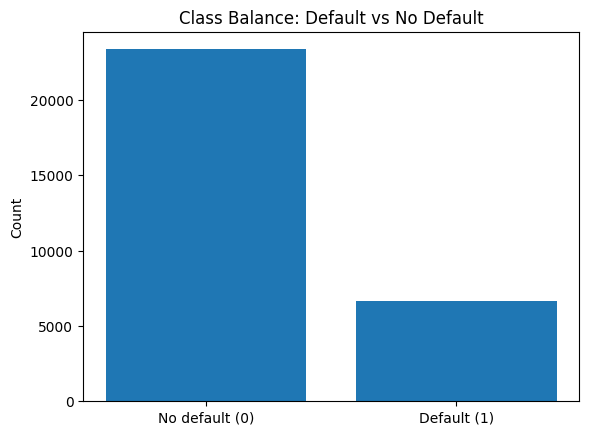

Default rate: 0.2212


In [7]:
counts = df[target_col].value_counts().sort_index()
rate = counts / counts.sum()

plt.figure()
plt.bar(["No default (0)", "Default (1)"], [counts.get(0, 0), counts.get(1, 0)])
plt.title("Class Balance: Default vs No Default")
plt.ylabel("Count")
plt.show()

print("Default rate:", float(rate.get(1, 0)))

In [8]:
pay_status_cols = [c for c in df.columns if c.startswith("pay_") and c not in ["pay_amt1","pay_amt2","pay_amt3","pay_amt4","pay_amt5","pay_amt6"]]
bill_cols = [c for c in df.columns if c.startswith("bill_amt")]
pay_amt_cols = [c for c in df.columns if c.startswith("pay_amt")]
demo_cols = ["sex", "education", "marriage", "age"]
account_cols = ["limit_bal"]

print("Pay status cols:", pay_status_cols)
print("Bill cols:", bill_cols)
print("Payment amount cols:", pay_amt_cols)

Pay status cols: ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
Bill cols: ['bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6']
Payment amount cols: ['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']


In [9]:
cat_like = ["sex", "education", "marriage"]

for c in cat_like:
    print(f"\n{c} unique values:", sorted(df[c].unique().tolist()))


sex unique values: [1, 2]

education unique values: [0, 1, 2, 3, 4, 5, 6]

marriage unique values: [0, 1, 2, 3]


In [10]:
for c in ["pay_0","pay_2","pay_3","pay_4","pay_5","pay_6"]:
    vals = sorted(df[c].unique().tolist())
    print(c, "min:", min(vals), "max:", max(vals), "sample:", vals[:10], "...", vals[-5:])

pay_0 min: -2 max: 8 sample: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7] ... [4, 5, 6, 7, 8]
pay_2 min: -2 max: 8 sample: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7] ... [4, 5, 6, 7, 8]
pay_3 min: -2 max: 8 sample: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7] ... [4, 5, 6, 7, 8]
pay_4 min: -2 max: 8 sample: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7] ... [4, 5, 6, 7, 8]
pay_5 min: -2 max: 8 sample: [-2, -1, 0, 2, 3, 4, 5, 6, 7, 8] ... [4, 5, 6, 7, 8]
pay_6 min: -2 max: 8 sample: [-2, -1, 0, 2, 3, 4, 5, 6, 7, 8] ... [4, 5, 6, 7, 8]


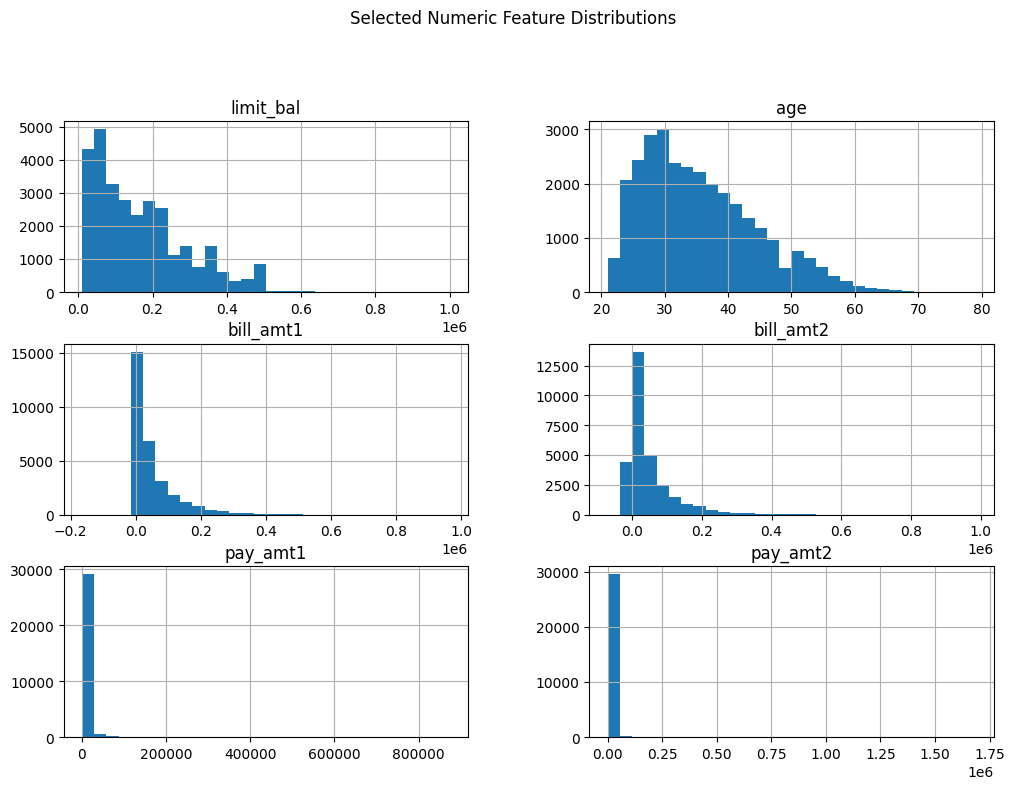

In [11]:
numeric_to_plot = ["limit_bal", "age"] + bill_cols[:2] + pay_amt_cols[:2]

df[numeric_to_plot].hist(bins=30, figsize=(12, 8))
plt.suptitle("Selected Numeric Feature Distributions", y=1.02)
plt.show()

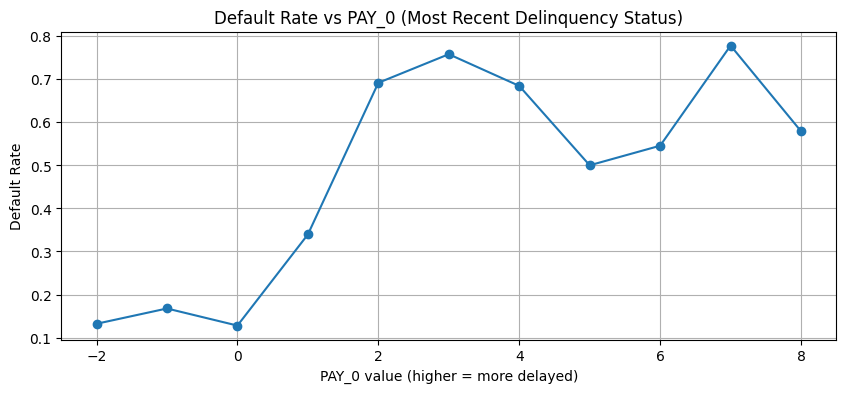

pay_0
-2    0.132294
-1    0.167781
 0    0.128113
 1    0.339479
 2    0.691414
 3    0.757764
 4    0.684211
 5    0.500000
 6    0.545455
 7    0.777778
 8    0.578947
Name: default_payment_next_month, dtype: float64

In [12]:
# Default rate by most recent payment status
group = df.groupby("pay_0")[target_col].mean().sort_index()

plt.figure(figsize=(10,4))
plt.plot(group.index, group.values, marker="o")
plt.title("Default Rate vs PAY_0 (Most Recent Delinquency Status)")
plt.xlabel("PAY_0 value (higher = more delayed)")
plt.ylabel("Default Rate")
plt.grid(True)
plt.show()

display(group)

ETL Rules (v1)

Keep columns

Keep all business-relevant columns.

Keep id as identifier (not a model feature).

Keep target default_payment_next_month as label.

Column types

Identifier: id

Target: default_payment_next_month (0/1)

Categorical-like (coded integers): sex, education, marriage

Ordinal delinquency: pay_0, pay_2, pay_3, pay_4, pay_5, pay_6

Numeric amounts: limit_bal, bill_amt1..6, pay_amt1..6, age

Cleaning

Fix “double header” row if present.

Normalize column names to snake_case.

Convert all columns to numeric.

Handle category mismatches:

education: map {0,5,6} → 4 (“other/unknown”) to align with documented categories

marriage: map {0} → 3 (“other/unknown”)

Do not drop negative bill amounts (they can represent credits/refunds).

No missing value imputation expected, but code should be robust:

numeric NaNs → fill with median

categorical NaNs → fill with mode

Encoding

ETL will store cleaned integer-coded categories in SQLite.

Model training will handle one-hot encoding + scaling using a ColumnTransformer pipeline.